In [1]:
# CS 194-26 Final Project #2 Image Quilting
# Authors: Glenn Wysen and Morgan Nanez

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage
from skimage import io, transform, color, filters
import numpy as np
import matplotlib.pyplot as plt
import functools
import random
import cv2
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve

In [2]:
text_tex = io.imread('samples/text_small.jpg') / 255
brick_tex = io.imread('samples/bricks_small.jpg') / 255
white_tex = io.imread('samples/white_small.jpg') / 255
face = io.imread('samples/feynman.tiff') / 255
sketch = io.imread('samples/sketch.tiff') / 255
biden = io.imread('samples/joe.jpg') / 255
joebiden = io.imread('samples/joebiden.jpg') / 255
oil_tex = io.imread('samples/oil.jpg') / 255
strawberry_tex = io.imread('samples/strawberry.jpg') / 255

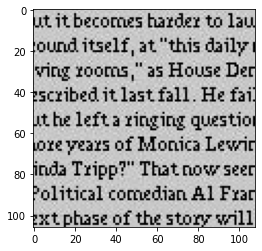

In [4]:
plt.imshow(text_tex)
plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

In [5]:
def quilt_random(sample, outsize, patchsize):
    # Randomly samples squares of size patchsize from sample and tiles them into an output image of size outsize
    assert patchsize < min(sample.shape[:2]), 'Patch size larger than input sample texture'
    output = np.zeros((outsize))
    offsetY_range = int(sample.shape[0] - patchsize)
    offsetX_range = int(sample.shape[1] - patchsize)
    for y in range(outsize[0] // patchsize):
        for x in range(outsize[1] // patchsize):
            offsetY = int(np.floor(random.random() * offsetY_range))
            offsetX = int(np.floor(random.random() * offsetX_range))
            patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
            output[y * patchsize:y * patchsize + patchsize, x * patchsize:x * patchsize + patchsize] = patch
    return output     

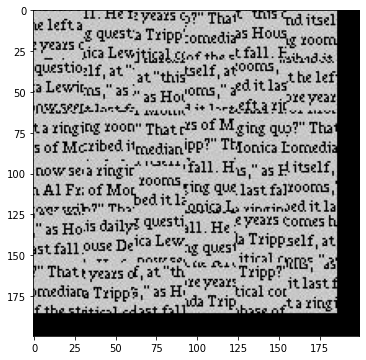

In [6]:
# good white_tex params
# big_size = [150, 150, 3]
# patchsize = 25
# texture = white_tex

# good brick_tex params
# big_size = [250, 250, 3]
# patchsize = 49
# texture = brick_tex

# good text_tex params
big_size = [200, 200, 3]
patchsize = 31
texture = text_tex


rand_quilt = quilt_random(texture, big_size, patchsize)
plt.imshow(rand_quilt)
# plt.savefig('random.jpg')
plt.show()

In [7]:
def generate_costs_both(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[overlap:, overlap:] = [0, 0, 0]
            diff = test_patch - output_patch
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.min(costmap[costmap >= 0])
    return costmap, mincost

In [8]:
def generate_costs_left(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[:, overlap:] = [0, 0, 0]
            diff = test_patch - output_patch
#             plt.imshow(test_patch)
#             plt.show()
#             plt.imshow(output_patch)
#             plt.show()
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.amin(costmap)
    return costmap, mincost

In [9]:
def generate_costs_top(sample, output_patch, overlap):
    patch_size = output_patch.shape[0]
    # starting 999 value chosen for filtering out bad points later
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 999
    for y in range(patch_size // 2, sample.shape[0] - patch_size // 2):
        for x in range(patch_size // 2, sample.shape[1] - patch_size // 2):
            test_patch = sample.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch[overlap:, :] = [0, 0, 0]
            diff = test_patch - output_patch
            cost = np.sum(diff**2)
            costmap[y, x] = cost
    mincost = np.amin(costmap)
    return costmap, mincost

In [10]:
def quilt_simple(sample, outsize, patchsize, overlap, tol):
    assert patchsize % 2 == 1, 'Patchsize must be odd in order to sample based off the center'
    output = np.zeros((outsize))
    
    # Placing a random patch into the top left
    offsetY = int(np.floor(random.random() * (sample.shape[0] - patchsize)))
    offsetX = int(np.floor(random.random() * (sample.shape[1] - patchsize)))
    
#     offsetY = 0
#     offsetX = 0
    
    rand_patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
    output[0: patchsize, 0:patchsize] = rand_patch 
    for y in range(0, outsize[0] // (patchsize - overlap)):
        for x in range(0, outsize[1] // (patchsize - overlap)):
            if y == 0 and x == 0:
                continue
            ymin = y * (patchsize - overlap)
            ymax = y * (patchsize - overlap) + patchsize
            xmin = x * (patchsize - overlap)
            xmax = x * (patchsize - overlap) + patchsize

            patch = output[ymin:ymax, xmin:xmax]
  
            if y == 0:
                costmap, mincost = generate_costs_left(sample, patch, overlap)
            elif x == 0:
                costmap, mincost = generate_costs_top(sample, patch, overlap)
            else:
                costmap, mincost = generate_costs_both(sample, patch, overlap)
                
            good_points = costmap < max(mincost * (1 + tol), .1)
            good_centers = np.transpose(good_points.nonzero())
#             print(len(good_centers))
            rand_center = good_centers[np.random.randint(len(good_centers))]
            fill_patch = sample[rand_center[0] - patchsize // 2:rand_center[0] + patchsize // 2 + 1, 
                                rand_center[1] - patchsize // 2:rand_center[1] + patchsize // 2 + 1]
            
            output[ymin:ymax, xmin:xmax] = fill_patch
#             plt.imshow(output)
#             plt.show()
    return output

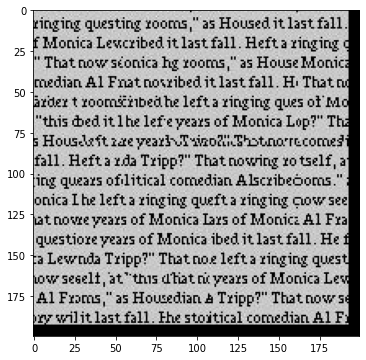

In [11]:
# good white_tex params
# big_size = [150, 150, 3]
# patchsize = 25
# overlap = 3
# texture = white_tex

# good brick_tex params
# big_size = [250, 250, 3]
# patchsize = 49
# overlap = 5
# texture = brick_tex

# good text_tex params
big_size = [200, 200, 3]
patchsize = 31
overlap = 4
texture = text_tex

better_quilt = quilt_simple(texture, big_size, patchsize, overlap, .1)
plt.imshow(better_quilt)
# plt.savefig('overlap.jpg')
plt.show()

# Seam Carving

In [1]:
def get_energy(img):
    vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1],])
    vertical = np.stack([vertical] * 3, axis=2)

    horizontal = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1],])
    horizontal = np.stack([horizontal] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.abs(convolve(img, vertical)) + np.abs(convolve(img, horizontal))

    final_energy = convolved.sum(axis=2)
    return final_energy

In [2]:
def min_seam(image):
    r, c, _ = image.shape
    energy_map = get_energy(image)
    map_copy = energy_map.copy()
    backtrack = np.zeros_like(map_copy, dtype=np.int)
    for i in range(1, r):
        for j in range(c):
            if j == 0:
                idx = np.argmin(map_copy[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = map_copy[i - 1, idx + j]
            else:
                idx = np.argmin(map_copy[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = map_copy[i - 1, idx + j - 1]
            map_copy[i, j] += min_energy
    return map_copy, backtrack

In [4]:
def vert_mask(img):
    r, c, _ = img.shape

    M, backtrack = min_seam(img)
    
    mask = np.ones((r, c), dtype=np.bool)

    j = np.argmin(M[-1])

    for i in range(r):
        mask[r - i - 1, j] = False
        j = backtrack[r - i - 1, j]

    for y in range(mask.shape[0]):
        change = False
        for x in range(mask.shape[1]):
            if not mask[y][x]:
                change = True
            if change:
                mask[y][x] = False
    return mask

In [5]:
def horizontal_mask(img):
    img = np.rot90(img, 1, (0, 1))
    img = vert_mask(img)
    img = np.rot90(img, 3, (0, 1))
    return img

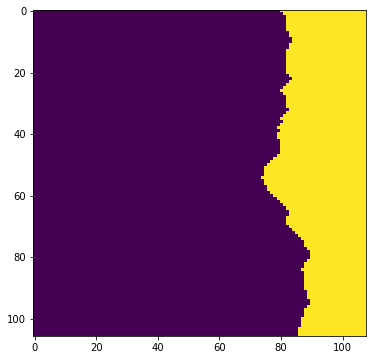

In [14]:
small_text = vert_mask(text_tex)
small_text = (small_text - 1) * -1
plt.imshow(small_text)
plt.show()

In [112]:
def merge_patch_left(input_orig_patch, input_patch, overlap):
    new_patch = input_patch.copy()
    orig_patch = input_orig_patch.copy()
    diff2 = (orig_patch - new_patch)**2
    overlap_section = diff2[:,:overlap]
    mask = vert_mask(overlap_section)
    inv_mask = np.zeros((new_patch.shape[0], new_patch.shape[1]))
    inv_mask[:,:overlap] = mask
    real_mask = (inv_mask - 1) * -1
    output = new_patch.copy()
#     plt.imshow(orig_patch)
#     plt.savefig('left patch.jpg')
#     plt.show()
#     plt.clf()
#     plt.imshow(new_patch)
#     plt.savefig('right patch.jpg')
#     plt.show()
#     plt.clf()
#     plt.imshow(diff2)
#     plt.savefig('diff patch.jpg')
#     plt.show()
#     plt.clf()
#     print(np.amax(overlap_section))
#     overlap_section = overlap_section / np.amax(overlap_section)
    for y in range(new_patch.shape[0]):
        marked = False
        for x in range(new_patch.shape[1]):
#             if marked == False and real_mask[y][x]:
#                 marked = True
#                 overlap_section[y][x] = [1, 0, 0]
            output[y][x] = real_mask[y][x] * new_patch[y][x] + inv_mask[y][x] * orig_patch[y][x]
#     plt.imshow(overlap_section)
#     plt.savefig('diff with seam.jpg')
#     plt.show()
#     plt.clf()
    return output

In [113]:
def merge_patch_top(input_orig_patch, input_patch, overlap):
    new_patch = input_patch.copy()
    orig_patch = input_orig_patch.copy()

    diff2 = (orig_patch - new_patch)**2
    overlap_section = diff2[:overlap,:]
    mask = horizontal_mask(overlap_section)
    inv_mask = np.zeros((new_patch.shape[0], new_patch.shape[1]))
    inv_mask[:overlap,:] = mask
    real_mask = (inv_mask - 1) * -1
    output = new_patch.copy()
    for y in range(new_patch.shape[0]):
        for x in range(new_patch.shape[1]):
            output[y][x] = real_mask[y][x] * new_patch[y][x] + inv_mask[y][x] * orig_patch[y][x]
    return output

In [114]:
def merge_patch_both(input_orig_patch, input_patch, overlap):
    new_patch = input_patch.copy()
    orig_patch = input_orig_patch.copy()

    diff2 = (orig_patch - new_patch)**2
    overlap_section_top = diff2[:overlap,:]
    overlap_section_left = diff2[:,:overlap]

    mask_top = horizontal_mask(overlap_section_top)
    mask_left = horizontal_mask(overlap_section_left)

        
    inv_mask_top = np.zeros((new_patch.shape[0], new_patch.shape[1]))
    inv_mask_top[:overlap,:] = mask_top
           
    inv_mask_left = np.zeros((new_patch.shape[0], new_patch.shape[1]))
    inv_mask_left[:,:overlap] = mask_left
    
    inv_mask = np.zeros((new_patch.shape[0], new_patch.shape[1]))

    inv_mask[:,:overlap] = mask_left
    inv_mask[:overlap,:] = mask_top
    inv_mask[:overlap,:overlap] = mask_top[:,:overlap] * mask_left[:overlap,:]
    if np.amax(inv_mask) == 0:
        return new_patch
    real_mask = (inv_mask - 1) * -1
    output = new_patch.copy()
    for y in range(new_patch.shape[0]):
        for x in range(new_patch.shape[1]):
            output[y][x] = real_mask[y][x] * new_patch[y][x] + inv_mask[y][x] * orig_patch[y][x]
    return output

In [115]:
def quilt_cut(sample, outsize, patchsize, overlap, tol):
    assert patchsize % 2 == 1, 'Patchsize must be odd in order to sample based off the center'
    output = np.zeros((outsize))
    
    # Placing a random patch into the top left
    offsetY = int(np.floor(random.random() * (sample.shape[0] - patchsize)))
    offsetX = int(np.floor(random.random() * (sample.shape[1] - patchsize)))
    
#     offsetY = 0
#     offsetX = 0
    
    rand_patch = sample[offsetY:offsetY + patchsize, offsetX:offsetX + patchsize]
    output[0: patchsize, 0:patchsize] = rand_patch 
    
    for y in range(0, outsize[0] // (patchsize - overlap)):
        for x in range(0, outsize[1] // (patchsize - overlap)):
            if y == 0 and x == 0:
                continue
            ymin = y * (patchsize - overlap)
            ymax = y * (patchsize - overlap) + patchsize
            xmin = x * (patchsize - overlap)
            xmax = x * (patchsize - overlap) + patchsize

            patch = output[ymin:ymax, xmin:xmax]
  
            if y == 0:
                costmap, mincost = generate_costs_left(sample, patch, overlap)
            elif x == 0:
                costmap, mincost = generate_costs_top(sample, patch, overlap)
            else:
                costmap, mincost = generate_costs_both(sample, patch, overlap)
                
            good_points = costmap < max(mincost * (1 + tol), 0.1)
            good_centers = np.transpose(good_points.nonzero())
            rand_center = good_centers[np.random.randint(len(good_centers))]
            fill_patch = sample[rand_center[0] - patchsize // 2:rand_center[0] + patchsize // 2 + 1, 
                                rand_center[1] - patchsize // 2:rand_center[1] + patchsize // 2 + 1]
            if y == 0:
                merged_patch = merge_patch_left(patch, fill_patch, overlap)
            elif x == 0:
                merged_patch = merge_patch_top(patch, fill_patch, overlap)
            else:
                merged_patch = merge_patch_both(patch, fill_patch, overlap)
                
            output[ymin:ymax, xmin:xmax] = merged_patch
#             plt.imshow(output)
#             plt.show()
    return output

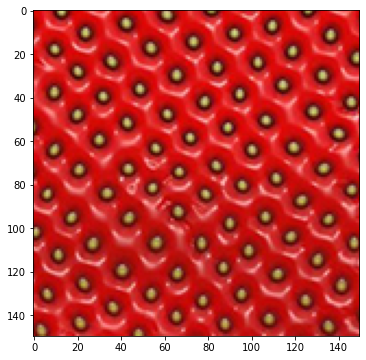

In [151]:
plt.imshow(strawberry_tex)
plt.show()

In [166]:
big_size = [500, 500, 3]
patchsize = 79
overlap = 10
texture = strawberry_tex

best_quilt = quilt_cut(texture, big_size, patchsize, overlap, .1)

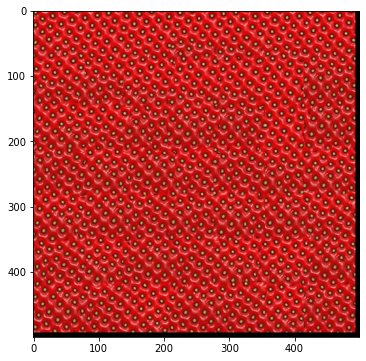

In [167]:
plt.imshow(best_quilt)
plt.savefig('big strawberry.jpg')
plt.show()

# Texture synthesis

In [16]:
def find_correspondence_left(patch_orig, patch_blur_orig, sample_orig, sample_blur_orig, alpha, overlap):
    patch = patch_orig.copy()
    patch_blur = patch_blur_orig.copy()
    sample = sample_orig.copy()
    sample_blur = sample_blur_orig.copy()

    
    patchsize = patch.shape[0]
    
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 9999

    patch[:, overlap:] = 0
    
    for y in range(patchsize // 2, sample.shape[0] - patchsize // 2):
        for x in range(patchsize // 2, sample.shape[1] - patchsize // 2):
            test_blur = sample_blur[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch = sample[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            correspondence = (1 - alpha) * np.sum((test_blur - patch_blur)**2)
            # only 0 instead of [0, 0, 0] because images are now grayscale
            test_patch[:, overlap:] = 0
            diff = test_patch - patch
#             plt.imshow(test_patch)
#             plt.show()
#             plt.imshow(patch)
#             plt.show()
#             return
            overlap_cost = alpha * np.sum(diff**2)
            costmap[y, x] = overlap_cost + correspondence
        
    mincost = np.amin(costmap)

    return costmap, mincost

In [17]:
def find_correspondence_top(patch_orig, patch_blur_orig, sample_orig, sample_blur_orig, alpha, overlap):
    patch = patch_orig.copy()
    patch_blur = patch_blur_orig.copy()
    sample = sample_orig.copy()
    sample_blur = sample_blur_orig.copy()

    
    patchsize = patch.shape[0]
    # Now that we're working with different images, the inital array can be set to zero because there is a negligable probablilty that 
    # there will be an indentical patch in the texture image and the source image.
    costmap = np.ones((sample.shape[0], sample.shape[1])) * 9999

    patch[:, overlap:] = 0
    
    for y in range(patchsize // 2, sample.shape[0] - patchsize // 2):
        for x in range(patchsize // 2, sample.shape[1] - patchsize // 2):
            test_blur = sample_blur[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch = sample[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            correspondence = (1 - alpha) * np.sum((test_blur - patch_blur)**2)
            # only 0 instead of [0, 0, 0] because images are now grayscale
            test_patch[overlap:, :] = 0
            diff = test_patch - patch
#             plt.imshow(test_patch)
#             plt.show()
#             plt.imshow(patch)
#             plt.show()
#             return
            overlap_cost = alpha * np.sum(diff**2)
            costmap[y, x] = overlap_cost + correspondence
        
    mincost = np.amin(costmap)

    return costmap, mincost

In [18]:
def find_correspondence_both(patch_orig, patch_blur_orig, sample_orig, sample_blur_orig, alpha, overlap):
    patch = patch_orig.copy()
    patch_blur = patch_blur_orig.copy()
    sample = sample_orig.copy()
    sample_blur = sample_blur_orig.copy()

    
    patchsize = patch.shape[0]

    costmap = np.ones((sample.shape[0], sample.shape[1])) * 9999

    patch[:, overlap:] = 0
    
    for y in range(patchsize // 2, sample.shape[0] - patchsize // 2):
        for x in range(patchsize // 2, sample.shape[1] - patchsize // 2):
            test_blur = sample_blur[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            test_patch = sample[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            correspondence = (1 - alpha) * np.sum((test_blur - patch_blur)**2)
            # only 0 instead of [0, 0, 0] because images are now grayscale
            test_patch[overlap:, overlap:] = 0
            diff = test_patch - patch
#             plt.imshow(test_patch)
#             plt.show()
#             plt.imshow(patch)
#             plt.show()
#             return
            overlap_cost = alpha * np.sum(diff**2)
            costmap[y, x] = overlap_cost + correspondence
        
    mincost = np.amin(costmap)

    return costmap, mincost

In [25]:
def texture_transfer(tex, image, patchsize, overlap, alpha, tol):
    tex_blur = filters.gaussian(rgb2gray(tex), sigma=2)
    image_blur = filters.gaussian(rgb2gray(image), sigma=2)

    output = np.zeros(image.shape)
    
    first_center = [-1, -1]
    patch = image_blur[:patchsize, :patchsize]
    min_correspondence = patchsize * patchsize
    for y in range(patchsize // 2, tex.shape[0] - patchsize // 2):
        for x in range(patchsize // 2, tex.shape[1] - patchsize // 2):
            test_patch = tex_blur.copy()[y - patchsize // 2:y + patchsize // 2 + 1, x - patchsize // 2:x + patchsize // 2 + 1]
            correspondence = np.sum((test_patch - patch)**2)
            if correspondence < min_correspondence:
                first_center = [y, x]
                min_correspondence = correspondence
    output[:patchsize, :patchsize] = tex.copy()[first_center[0] - patchsize // 2:first_center[0] + patchsize // 2 + 1, 
                                                first_center[1] - patchsize // 2:first_center[1] + patchsize // 2 + 1]

    big_count = 0
    for y in range(0, image.shape[0] // (patchsize - overlap)):
        for x in range(0, image.shape[1] // (patchsize - overlap)):
            if y == 0 and x == 0:
                continue
                
            ymin = y * (patchsize - overlap)
            ymax = y * (patchsize - overlap) + patchsize
            xmin = x * (patchsize - overlap)
            xmax = x * (patchsize - overlap) + patchsize

            patch = image[ymin:ymax, xmin:xmax]
            patch_blur = image_blur[ymin:ymax, xmin:xmax]
  
            if y == 0:
                costmap, mincost = find_correspondence_left(patch, patch_blur, tex, tex_blur, alpha, overlap)
            elif x == 0:
                costmap, mincost = find_correspondence_top(patch, patch_blur, tex, tex_blur, alpha, overlap)
            else:
                costmap, mincost = find_correspondence_both(patch, patch_blur, tex, tex_blur, alpha, overlap)
            
            good_points = costmap < max(mincost * (1 + tol), 0.1)
            good_centers = np.transpose(good_points.nonzero())
            rand_center = good_centers[np.random.randint(len(good_centers))]
            count = 0
            while rand_center[0] < patchsize // 2 or rand_center[0] > tex.shape[0] - patchsize // 2 or rand_center[1] < patchsize // 2 or rand_center[1] > tex.shape[1] - patchsize // 2:
                rand_center = good_centers[np.random.randint(len(good_centers))]
                count += 1
                if count == 1000:
                    print('Could not find good center.')
                    return

            fill_patch = tex[rand_center[0] - patchsize // 2:rand_center[0] + patchsize // 2 + 1, 
                                    rand_center[1] - patchsize // 2:rand_center[1] + patchsize // 2 + 1]

            current_patch = output[ymin:ymax, xmin:xmax]
            if y == 0:
                merged_patch = merge_patch_left(current_patch, fill_patch, overlap)
            elif x == 0:
                merged_patch = merge_patch_top(current_patch, fill_patch, overlap)
            else:
                merged_patch = merge_patch_both(current_patch, fill_patch, overlap)
            

            output[ymin:ymax, xmin:xmax] = merged_patch
            print('.',end='')
            if x == 0 and y % 2 == 0:
                plt.imshow(output)
                plt.show()
            big_count += 1
    return output
    

In [26]:
print(joebiden.shape)

(800, 639, 3)


......................................................................

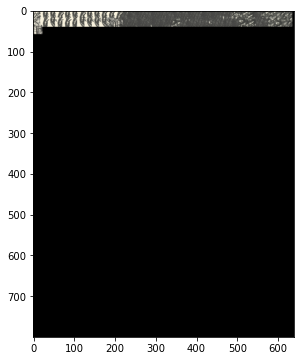

......................................................................

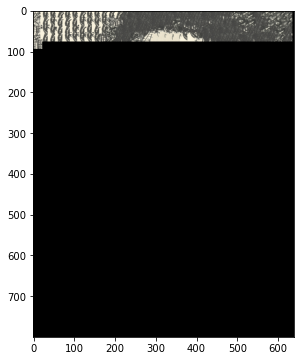

......................................................................

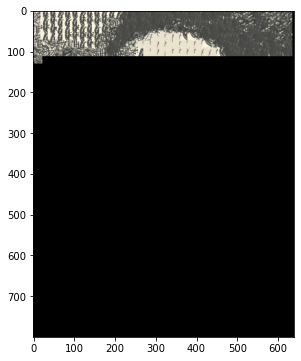

......................................................................

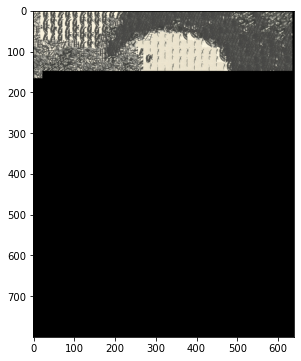

......................................................................

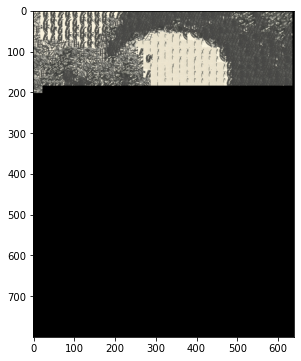

......................................................................

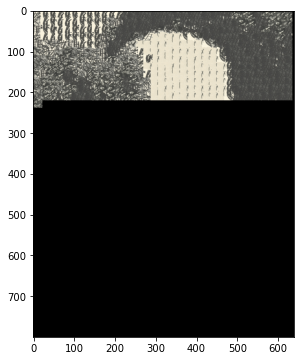

......................................................................

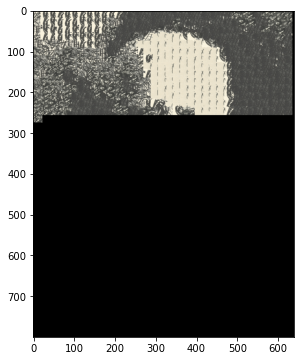

......................................................................

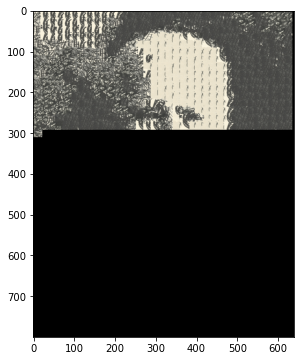

......................................................................

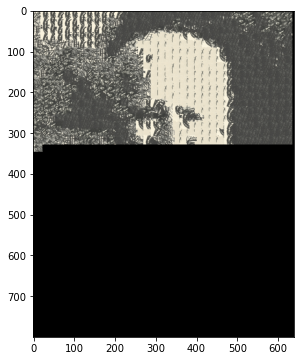

......................................................................

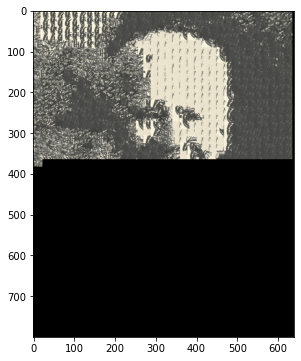

............

KeyboardInterrupt: 

In [27]:
# takes a bit to run (around 3-5 minutes I think)
transfered_face = texture_transfer(sketch, joebiden, 23, 5, 0.3, 0.05)

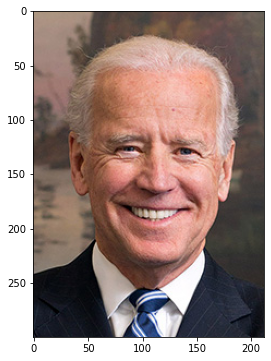

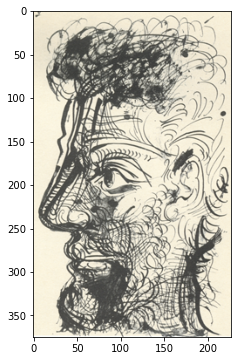

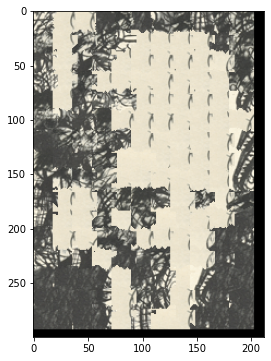

In [52]:
plt.imshow(biden)
plt.show()
plt.imshow(sketch)
plt.show()
plt.imshow(transfered_face)
plt.show()

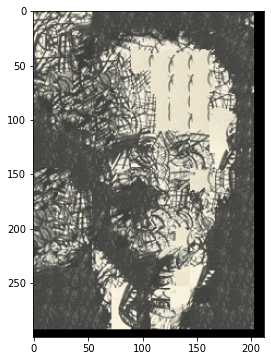

In [53]:
plt.imshow(point_1)
plt.savefig('biden.jpg')
plt.show()